# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [371]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [372]:
# on MacOS
# Load CSV using Pandas
data_tr = pd.read_csv('./data_sentiment/train.csv', names=['text','label'])
data_dev = pd.read_csv('./data_sentiment/dev.csv', names=['text','label'])
data_test = pd.read_csv('./data_sentiment/test.csv', names=['text','label'])

If you use Pandas you can see a sample of the data.

In [373]:
data_tr.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [374]:
train_label = Y_tr = data_tr['label'].values
train_text = X_tr_raw = list(data_tr['text'])
dev_label = Y_dev = data_dev['label'].values
dev_text = X_dev_raw = list(data_dev['text'])
test_label = Y_te = data_test['label'].values
test_text = X_te_raw = list(data_test['text'])

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [375]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [376]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):    
    
    tokenized_list = re.findall(token_pattern,x_raw)    
    tokenized_list_without_sw = [word for word in tokenized_list if word not in stop_words] # remove stopword
    
    ngram_list = []
    for gram_num in range(ngram_range[0],ngram_range[1] + 1):   #input is (1,3) we need 1 to 3
        if gram_num == 1:                                       #unigram
            ngram_list = tokenized_list_without_sw[:]           #slice
            continue
        else:
            for i in range(len(tokenized_list_without_sw) - (gram_num - 1)):
                ngram_list.append(tuple(tokenized_list_without_sw[i:i + gram_num]))
    # set vocab
    if vocab == set():
        return ngram_list
    else:
        ngram_list = [word for word in ngram_list if word in vocab] # remove word not in vocab
        return ngram_list

In [377]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [378]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [379]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):

    ngram_list = []
    for i in range(len(X_raw)):
        ngram_list.extend(list(set(extract_ngrams(X_raw[i], ngram_range=ngram_range, stop_words=stop_words))))
        #use set to delete repeat word

    df = Counter(ngram_list)
    ngram_counts = df.most_common()[:keep_topN]
    vocab = [ngram_counts[i][0] for i in range(len(ngram_counts))]
    return vocab, df, ngram_counts  

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [380]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['but', 'one', 'film', 'not', 'all', 'movie', 'out', 'so', 'there', 'like', 'more', 'up', 'about', 'when', 'some', 'if', 'just', 'only', 'into', 'than', 'even', 'their', 'time', 'most', 'no', 'good', 'much', 'him', 'would', 'other', 'get', 'story', 'well', 'will', 'also', 'two', 'after', 'first', 'character', 'make', 'way', 'characters', 'off', 'see', 'very', 'while', 'does', 'any', 'where', 'too', 'little', 'plot', 'because', 'over', 'director', 'had', 'how', 'then', 'best', 'being', 'people', 'doesn', 'really', 'man', 'never', 'life', 'through', 'films', 'here', 'don', 'many', 'another', 'such', 'scene', 'me', 'bad', 'know', 'made', 'scenes', 'my', 'end', 'new', 'go', 'before', 'back', 'makes', 'something', 'great', 'work', 'movies', 'still', 'better', 'now', 'few', 'down', 'seems', 'around', 'every', 'enough', 're']

[('but', 1334), ('one', 1247), ('film', 1231), ('not', 1170), ('all', 1117), ('movie', 1095), ('out', 1080), ('so', 1047), ('there', 1046), ('like', 1043)]


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [381]:
word2id = {}
for i in range(len(vocab)):
    word2id[vocab[i]] = i

id2word = {}
id2word = vocab[:]

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [382]:
# create a function
def data_ngrams(text):
    ngrams = []
    for i in range(len(text)):
        ngrams.append(extract_ngrams(text[i], stop_words=stop_words, vocab=vocab))
    return ngrams
# extract ngrams
train_ngrams = data_ngrams(train_text) 
dev_ngrams = data_ngrams(dev_text)
test_ngrams = data_ngrams(test_text)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [383]:
def vectorise(X_ngram, vocab):
    X_vec = np.zeros((len(X_ngram),len(vocab))) # create a zreo matrix
    for i in range(len(X_ngram)):               
        for j in range(len(X_ngram[i])):      
            idx = word2id[X_ngram[i][j]]        # find id
            X_vec[i,idx] += 1                   # count
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [384]:
X_tr_count = vectorise(train_ngrams,vocab)
X_dev_count = vectorise(dev_ngrams,vocab)
X_te_count = vectorise(test_ngrams,vocab)

In [385]:
X_tr_count.shape

(1400, 5000)

In [386]:
X_tr_count[:2,:50]

array([[ 6.,  8., 20.,  4.,  1.,  0.,  1.,  3.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  2.,  4.,  2.,  1.,  3.,  6.,  0.,  4.,  1.,  1.,
         1.,  0.,  3.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  2.,  3.,
         0.,  0.,  4.,  1.,  1.,  0.,  3.,  0.,  1.,  1.,  0.],
       [ 2.,  5.,  6.,  2.,  4.,  0.,  2.,  3.,  2.,  3.,  3.,  4.,  2.,
         0.,  2.,  2.,  0.,  0.,  2.,  3.,  0.,  0.,  2.,  2.,  1.,  1.,
         1.,  5.,  1.,  1.,  1.,  2.,  0.,  4.,  1.,  1.,  0.,  0.,  5.,
         1.,  2.,  0.,  0.,  1.,  0.,  3.,  1.,  1.,  2.,  0.]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [387]:
df_vocab = np.zeros((len(vocab),))
for j in range(len(train_ngrams)):
    for i in range(len(vocab)):
        if vocab[i] in train_ngrams[j]:
            df_vocab[i] += 1               #count
#idfs
idfs = np.log(len(train_ngrams)/(df_vocab + 1))

Then transform your count vectors to tf.idf vectors:

In [388]:
X_tr_tfidf = X_tr_count * idfs   # mathematical formula
X_dev_tfidf = X_dev_count * idfs
X_te_tfidf = X_te_count * idfs

In [389]:
X_tr_tfidf[1,:50]

array([0.09508189, 0.57464983, 0.76700023, 0.3572283 , 0.89972345,
       0.        , 0.5171714 , 0.86876595, 0.58108661, 0.88023824,
       0.88887134, 1.26275879, 0.65106459, 0.        , 0.74212736,
       0.79669528, 0.        , 0.        , 0.83753496, 1.28247491,
       0.        , 0.        , 0.94000726, 0.99328198, 0.50370816,
       0.52763274, 0.5558728 , 2.86097285, 0.58878717, 0.59265564,
       0.59913655, 1.20087556, 0.        , 2.44890295, 0.61618614,
       0.62016229, 0.        , 0.        , 3.1609324 , 0.68037199,
       1.36356684, 0.        , 0.        , 0.70464156, 0.        ,
       2.17081916, 0.74293785, 0.74444047, 1.50700796, 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [390]:
def sigmoid(z):
    z = 1.0/(1 + np.exp(-z)) # mathematical formula
    return z

In [391]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [392]:
def predict_proba(X, weights):
    
    preds_proba = sigmoid(np.dot(X, weights)) 
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [393]:
def predict_class(X, weights):
    # create a matrix shape like predict_proba
    preds_class = np.zeros_like(predict_proba(X, weights)) 
    
    for i in range(len(predict_proba(X, weights))):
        if predict_proba(X, weights)[i] >= 0.5:      #decision bound
            preds_class[i] = 1
        else:
            preds_class[i] = 0
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [394]:
def binary_loss(X, Y, weights, alpha=0.00001):
    prediction = predict_proba(X, weights)
    # minimise the binary cross-entropy loss
    #l = -np.dot(Y.T, np.log(prediction)) - np.dot(Y.T, np.log(1-prediction)) + alpha*np.dot(weights,weights.T)
    l = 0
    for i in range(len(Y)):                  # -ylog(y) - (1-y)log(1-y)
        if Y[i] == 1:
            l += -np.log(prediction[i])
        else:
            l += -np.log(1-prediction[i])
    l += alpha * np.linalg.norm(weights)     # l2 regulization
    
    return l

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [514]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    weights = np.random.uniform(low=-0.1, high=0.1, size=(X_tr_tfidf.shape[1],)) #initialization
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    stop_flag = 0
    idx = np.arange(len(X_tr))
    np.random.shuffle(idx)                              # shuffle data
    loop_tr = 10                                        # split train into 10 small set
    batch_size = int(len(X_tr)/loop_tr)
    len_dataset = len(X_tr)
    for k in range(epochs):                             # multiple passes (epochs)
        loss_count = 0
        idx = np.arange(len(X_tr))
        np.random.shuffle(idx)                          # shuffle data 
        for i in range(loop_tr):
            temp_idx = idx[i*batch_size:(i+1)*batch_size]
            temp_label = Y_tr[temp_idx]
            temp_data = X_tr[temp_idx]
            #update weights 
            weights = weights - lr * (np.dot(temp_data.T, (sigmoid(np.dot(temp_data, weights)) - temp_label)) + alpha * weights) 
            #Binary Cross-entropy loss function
            loss_count += binary_loss(temp_data,temp_label, weights) #count
        loss_dev = binary_loss(X_dev,Y_dev, weights)

        threshold = 0.0001
        if k > 1 and cur_loss_dev - loss_dev/Y_dev.shape[0] < threshold and stop_flag == 0:
            stop_flag = 1
        elif k > 1 and cur_loss_dev - loss_dev/Y_dev.shape[0] > threshold and stop_flag == 1:
            stop_flag = 0 
        elif k > 1 and cur_loss_dev - loss_dev/Y_dev.shape[0] < threshold and stop_flag == 1:
            break 
        # stop training if the difference between the current and previous validation loss is smaller than a threshold
        cur_loss_tr = loss_count/len_dataset
        cur_loss_dev = loss_dev/Y_dev.shape[0]
        print(f'Epoch{k}:training loss:{round(cur_loss_tr,4)},evaluating loss:{round(cur_loss_dev,4)}')
        #print
        
        training_loss_history.append(cur_loss_tr)
        validation_loss_history.append(cur_loss_dev)

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [398]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

Epoch0:training loss:0.8295,evaluating loss:0.7866
Epoch1:training loss:0.7653,evaluating loss:0.7482
Epoch2:training loss:0.7135,evaluating loss:0.7191
Epoch3:training loss:0.6748,evaluating loss:0.6989
Epoch4:training loss:0.6369,evaluating loss:0.6768
Epoch5:training loss:0.607,evaluating loss:0.6584
Epoch6:training loss:0.5819,evaluating loss:0.6434
Epoch7:training loss:0.557,evaluating loss:0.6301
Epoch8:training loss:0.5357,evaluating loss:0.6205
Epoch9:training loss:0.5169,evaluating loss:0.6096
Epoch10:training loss:0.4997,evaluating loss:0.5994
Epoch11:training loss:0.4848,evaluating loss:0.5954
Epoch12:training loss:0.4706,evaluating loss:0.584
Epoch13:training loss:0.4587,evaluating loss:0.5783
Epoch14:training loss:0.4471,evaluating loss:0.5718
Epoch15:training loss:0.436,evaluating loss:0.5654
Epoch16:training loss:0.426,evaluating loss:0.5612
Epoch17:training loss:0.4154,evaluating loss:0.5553
Epoch18:training loss:0.4065,evaluating loss:0.551
Epoch19:training loss:0.3981

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

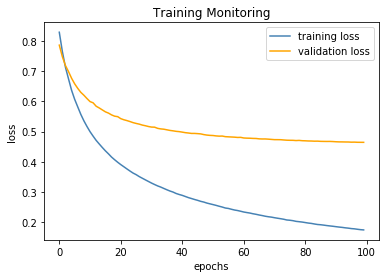

In [466]:
sub_axis = np.arange(len(loss_tr_count))
plt.title('Training Monitoring')
plt.plot(sub_axis, loss_tr_count, color='steelblue', label='training loss')
plt.plot(sub_axis, dev_loss_count, color='orange', label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

**<mark>Typical overfitting. Because validation loss becomes stable but training loss still decreases<mark>**

Compute accuracy, precision, recall and F1-scores:

In [400]:
preds_te_count = predict_class(X_te_count, w_count)
print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.7925
Precision: 0.7772511848341233
Recall: 0.82
F1-Score: 0.7980535279805353


Finally, print the top-10 words for the negative and positive class respectively.

In [401]:
pos_10_idx = np.argsort(w_count[:])[-10:]
pos_10_words = list(np.array(vocab)[pos_10_idx])
print(pos_10_words)

['yet', 'hilarious', 'seen', 'way', 'see', 'pulp', 'right', 'others', 'well', 'great']


In [402]:
neg_10_idx = np.argsort(w_count[:])[:10]
neg_10_words = list(np.array(vocab)[neg_10_idx])
print(neg_10_words)

['bad', 'worst', 'only', 'looks', 'plot', 'director', 'script', 'mess', 'why', 'waste']


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Provide your answer here...

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [430]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=50)

Epoch0:training loss:1.2809,evaluating loss:1.3966
Epoch1:training loss:1.0205,evaluating loss:1.2519
Epoch2:training loss:0.8364,evaluating loss:1.1618
Epoch3:training loss:0.7039,evaluating loss:1.0901
Epoch4:training loss:0.6037,evaluating loss:1.0298
Epoch5:training loss:0.5263,evaluating loss:0.9927
Epoch6:training loss:0.4635,evaluating loss:0.9445
Epoch7:training loss:0.4143,evaluating loss:0.9157
Epoch8:training loss:0.3743,evaluating loss:0.8885
Epoch9:training loss:0.3393,evaluating loss:0.8607
Epoch10:training loss:0.3121,evaluating loss:0.8415
Epoch11:training loss:0.2875,evaluating loss:0.8251
Epoch12:training loss:0.2663,evaluating loss:0.8072
Epoch13:training loss:0.2471,evaluating loss:0.7927
Epoch14:training loss:0.2306,evaluating loss:0.779
Epoch15:training loss:0.2158,evaluating loss:0.7633
Epoch16:training loss:0.203,evaluating loss:0.7528
Epoch17:training loss:0.1912,evaluating loss:0.7435
Epoch18:training loss:0.1809,evaluating loss:0.7323
Epoch19:training loss:0.

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

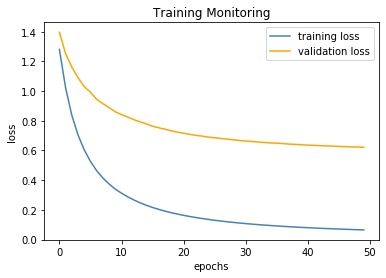

In [467]:
sub_axis = np.arange(len(trl))
plt.title('Training Monitoring')
plt.plot(sub_axis, trl, color='steelblue', label='training loss')
plt.plot(sub_axis, devl, color='orange', label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

**<mark>It about right. Because both of them decrease and become stable at same time.<mark>**

Compute accuracy, precision, recall and F1-scores:

In [440]:
preds_te_count = predict_class(X_te_tfidf, w_tfidf)
print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.775
Precision: 0.7722772277227723
Recall: 0.78
F1-Score: 0.7761194029850748


Print top-10 most positive and negative words:

In [441]:
pos_10_idx = np.argsort(w_tfidf[:])[-10:]
pos_10_words = list(np.array(vocab)[pos_10_idx])
print(pos_10_words)

['neighbor', 'fortunately', 'seen', 'rocky', 'definitely', 'rare', ('may', 'not'), 'memorable', 'overall', 'terrific']


In [442]:
neg_10_idx = np.argsort(w_tfidf[:])[:10]
neg_10_words = list(np.array(vocab)[neg_10_idx])
print(neg_10_words)

['disappointing', 'looks', 'stupid', 'mess', 'road', 'attempt', ('but', 'only'), 'least', 'none', ('bad', 'movie')]


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Using a 0.01 or 0.001 lr value to try. Then, decrease it and find a good value. Learning rate controls how quickly the model is adapted to the problem. Small learning rate need more learning epochs. Regularisation strength can help to avoid overfitting. 



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.78|0.82|0.80|
| BOW-tfidf  |0.77|0.78|0.78|


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [559]:
# like Task1
data_tr = pd.read_csv('./data_topic/train.csv', names=['label','text'])
data_dev = pd.read_csv('./data_topic/dev.csv', names=['label','text'])
data_test = pd.read_csv('./data_topic/test.csv', names=['label','text'])

In [560]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [561]:
train_label = Y_tr = data_tr['label'].values
train_text = X_tr_raw = list(data_tr['text'])
train_text = X_tr_raw = [word.lower() for word in train_text] #lower case

dev_label = Y_dev = data_dev['label'].values
dev_text = X_dev_raw = list(data_dev['text'])
dev_text = X_dev_raw = [word.lower() for word in dev_text]

test_label = Y_te = data_test['label'].values
test_text = X_te_raw = list(data_test['text'])
test_text = X_te_raw = [word.lower() for word in test_text]

In [562]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['reuters', 'said', 'tuesday', 'wednesday', 'new', 'after', 'ap', 'athens', 'monday', 'first', 'two', 'york', 'over', ('new', 'york'), 'us', 'olympic', 'but', 'their', 'will', 'inc', 'more', 'year', 'oil', 'prices', 'company', 'world', 'than', 'aug', 'about', 'had', 'united', 'one', 'out', 'sunday', 'into', 'against', 'up', 'second', 'last', 'president', 'stocks', 'gold', 'team', ('new', 'york', 'reuters'), ('york', 'reuters'), 'when', 'three', 'night', 'time', 'no', 'yesterday', 'games', 'olympics', 'not', 'states', 'greece', 'off', 'iraq', 'washington', 'percent', ('united', 'states'), ('oil', 'prices'), 'home', 'day', 'google', 'public', ('athens', 'reuters'), 'record', 'week', 'men', 'government', 'win', ('said', 'tuesday'), 'american', 'won', 'years', 'all', 'billion', 'shares', 'city', 'offering', 'officials', 'would', 'today', 'final', 'afp', 'gt', 'people', 'lt', 'medal', 'corp', 'sales', 'country', 'back', 'four', 'high', 'investor', 'com', 'minister', 'reported']

[('re

In [563]:
word2id = {}
for i in range(len(vocab)):
    word2id[vocab[i]] = i

id2word = {}
id2word = vocab[:]
# extract n-grams
train_ngrams = data_ngrams(train_text) 
dev_ngrams = data_ngrams(dev_text)
test_ngrams = data_ngrams(test_text)
#use vectoriser
X_tr_count = vectorise(train_ngrams,vocab)
X_dev_count = vectorise(dev_ngrams,vocab)
X_te_count = vectorise(test_ngrams,vocab)

print(X_tr_count.shape)
print(X_tr_count[:2,:50])

(2400, 5000)
[[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [564]:
df_vocab = np.zeros((len(vocab),))
for j in range(len(train_ngrams)):
    for i in range(len(vocab)):
        if vocab[i] in train_ngrams[j]:
            df_vocab[i] += 1               
#idfs
idfs = np.log(len(train_ngrams)/(df_vocab + 1))
#tfidf
X_tr_tfidf = X_tr_count * idfs             
X_dev_tfidf = X_dev_count * idfs
X_te_tfidf = X_te_count * idfs

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [565]:
def softmax(z):
    
    sum_exp = np.sum(np.exp(z),axis = -1)
    smax =  np.exp(z) / np.expand_dims(sum_exp, -1)  # expend dimension
    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [566]:
def predict_proba(X, weights):
    
    preds_proba = softmax(np.dot(X, weights))
    
    return preds_proba

In [567]:
def predict_class(X, weights):
    
    preds_class = np.argmax(predict_proba(X, weights), axis = -1) + 1
    
    return preds_class

Toy example and expected functionality of the functions above:

In [568]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [569]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [570]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [571]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    
    prediction = predict_proba(X, weights)
    l = 0
    for i in range(X.shape[0]):                 
        l += -np.log(prediction[i][Y[i]-1])
    
    l += alpha * np.linalg.norm(weights)
    
    return l
    

Finally you need to modify SGD to support the categorical cross entropy loss:

In [572]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    weights = np.random.uniform(low=-0.1, high=0.1, size=(X_tr_tfidf.shape[1],3)) 
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    stop_flag = 0
    idx = np.arange(len(X_tr))
    np.random.shuffle(idx)                              
    loop_tr = 10                                        
    batch_size = int(len(X_tr)/loop_tr)
    len_dataset = len(X_tr_count)
    for k in range(epochs):                             
        idx = np.arange(len(X_tr))
        np.random.shuffle(idx)                          
        for i in range(loop_tr):
            temp_idx = idx[i*batch_size:(i+1)*batch_size]
            temp_label = Y_tr[temp_idx] - 1
            temp_data = X_tr[temp_idx]
            onehot_label = np.eye(3)[temp_label] # one_hot vector
            weights = weights - lr * (np.dot(temp_data.T, (sigmoid(np.dot(temp_data, weights)) - onehot_label)) + alpha * weights) 
        loss_dev = categorical_loss(X_dev,Y_dev, weights)
        loss_tr = categorical_loss(X_tr,Y_tr, weights)
        
        threshold = 0.0001
        if k > 1 and cur_loss_dev - loss_dev/Y_dev.shape[0] < threshold and stop_flag == 0:
            stop_flag = 1
        elif k > 1 and cur_loss_dev - loss_dev/Y_dev.shape[0] > threshold and stop_flag == 1:
            stop_flag = 0 
        elif k > 1 and cur_loss_dev - loss_dev/Y_dev.shape[0] < threshold and stop_flag == 1:
            break 
        cur_loss_tr = loss_tr/len_dataset
        cur_loss_dev = loss_dev/Y_dev.shape[0]
        print(f'Epoch{k}:training loss:{round(cur_loss_tr,4)},evaluating loss:{round(cur_loss_dev,4)}')
        training_loss_history.append(cur_loss_tr)
        validation_loss_history.append(cur_loss_dev)

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [637]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch0:training loss:1.0934,evaluating loss:1.0942
Epoch1:training loss:1.0653,evaluating loss:1.0796
Epoch2:training loss:1.0399,evaluating loss:1.0659
Epoch3:training loss:1.0166,evaluating loss:1.0529
Epoch4:training loss:0.9952,evaluating loss:1.0405
Epoch5:training loss:0.9753,evaluating loss:1.0286
Epoch6:training loss:0.9567,evaluating loss:1.0171
Epoch7:training loss:0.9392,evaluating loss:1.0061
Epoch8:training loss:0.9227,evaluating loss:0.9954
Epoch9:training loss:0.907,evaluating loss:0.9851
Epoch10:training loss:0.892,evaluating loss:0.975
Epoch11:training loss:0.8778,evaluating loss:0.9653
Epoch12:training loss:0.8642,evaluating loss:0.9558
Epoch13:training loss:0.8512,evaluating loss:0.9467
Epoch14:training loss:0.8387,evaluating loss:0.9377
Epoch15:training loss:0.8267,evaluating loss:0.929
Epoch16:training loss:0.8152,evaluating loss:0.9205
Epoch17:training loss:0.8042,evaluating loss:0.9122
Epoch18:training loss:0.7935,evaluating loss:0.9042
Epoch19:training loss:0.78

Epoch158:training loss:0.3711,evaluating loss:0.4968
Epoch159:training loss:0.3701,evaluating loss:0.4957
Epoch160:training loss:0.3691,evaluating loss:0.4946
Epoch161:training loss:0.3682,evaluating loss:0.4936
Epoch162:training loss:0.3672,evaluating loss:0.4926
Epoch163:training loss:0.3662,evaluating loss:0.4915
Epoch164:training loss:0.3653,evaluating loss:0.4905
Epoch165:training loss:0.3643,evaluating loss:0.4895
Epoch166:training loss:0.3634,evaluating loss:0.4885
Epoch167:training loss:0.3625,evaluating loss:0.4875
Epoch168:training loss:0.3615,evaluating loss:0.4865
Epoch169:training loss:0.3606,evaluating loss:0.4855
Epoch170:training loss:0.3597,evaluating loss:0.4845
Epoch171:training loss:0.3588,evaluating loss:0.4835
Epoch172:training loss:0.3579,evaluating loss:0.4826
Epoch173:training loss:0.357,evaluating loss:0.4816
Epoch174:training loss:0.3561,evaluating loss:0.4807
Epoch175:training loss:0.3553,evaluating loss:0.4798
Epoch176:training loss:0.3544,evaluating loss:0

Plot training and validation process and explain if your model overfit, underfit or is about right:

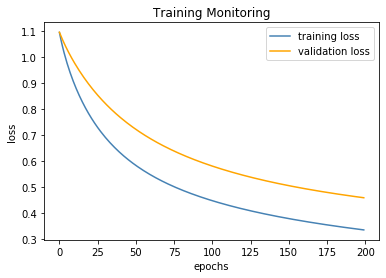

In [696]:
sub_axis = np.arange(len(loss_tr_count))
plt.title('Training Monitoring')
plt.plot(sub_axis, loss_tr_count, color='steelblue', label='training loss')
plt.plot(sub_axis, dev_loss_count, color='orange', label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

<mark>Right. Decrease in the meantime. <mark>

Compute accuracy, precision, recall and F1-scores:

In [697]:
preds_te_count = predict_class(X_te_count, w_count)
print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count,average = 'macro'))
print('Recall:', recall_score(Y_te,preds_te_count,average = 'macro'))
print('F1-Score:', f1_score(Y_te,preds_te_count,average = 'macro'))

Accuracy: 0.8433333333333334
Precision: 0.8456270292207791
Recall: 0.8433333333333334
F1-Score: 0.8417577258947558


Print the top-10 words for each class respectively.

In [698]:
#positive
pos_idx_1 = np.argsort(w_count[:,0])[-10:]
pos_idx_2 = np.argsort(w_count[:,1])[-10:]
pos_idx_3 = np.argsort(w_count[:,2])[-10:]
pos_10_words_1 = list(np.array(vocab)[pos_idx_1])
pos_10_words_2 = list(np.array(vocab)[pos_idx_2])
pos_10_words_3 = list(np.array(vocab)[pos_idx_3])
print('class1:',pos_10_words_1)
print('class2:',pos_10_words_2)
print('class3:',pos_10_words_3)

class1: ['region', 'iraqi', 'najaf', 'murder', 'troops', 'said', 'people', 'president', 'afp', 'minister']
class2: ['ap', 'when', 'game', 'olympics', 'games', 'win', ('athens', 'reuters'), 'team', 'olympic', 'athens']
class3: ['billion', 'corp', 'largest', 'profit', 'market', 'business', 'prices', 'oil', 'inc', 'company']


In [699]:
#negative 
neg_idx_1 = np.argsort(w_count[:,0])[:10]
neg_idx_2 = np.argsort(w_count[:,1])[:10]
neg_idx_3 = np.argsort(w_count[:,2])[:10]
neg_10_words_1 = list(np.array(vocab)[neg_idx_1])
neg_10_words_2 = list(np.array(vocab)[neg_idx_2])
neg_10_words_3 = list(np.array(vocab)[neg_idx_3])
print('class1:',neg_10_words_1)
print('class2:',neg_10_words_2)
print('class3:',neg_10_words_3)

class1: ['company', 'athens', 'when', 'olympic', 'team', 'inc', 'corp', 'reuters', ('athens', 'reuters'), 'time']
class2: ['said', 'company', 'oil', 'reuters', 'government', 'iraq', 'prices', 'inc', 'afp', 'president']
class3: ['ap', 'athens', 'olympic', 'sunday', 'two', 'afp', 'monday', 'first', 'night', 'team']


In [688]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0001, 
                         alpha=0.001, 
                         epochs=100)

Epoch0:training loss:1.1506,evaluating loss:1.2375
Epoch1:training loss:0.9514,evaluating loss:1.1059
Epoch2:training loss:0.8128,evaluating loss:1.0042
Epoch3:training loss:0.7114,evaluating loss:0.9236
Epoch4:training loss:0.6347,evaluating loss:0.8583
Epoch5:training loss:0.5747,evaluating loss:0.8042
Epoch6:training loss:0.5268,evaluating loss:0.7587
Epoch7:training loss:0.4876,evaluating loss:0.72
Epoch8:training loss:0.4548,evaluating loss:0.6867
Epoch9:training loss:0.427,evaluating loss:0.6578
Epoch10:training loss:0.4029,evaluating loss:0.6326
Epoch11:training loss:0.3819,evaluating loss:0.6104
Epoch12:training loss:0.3634,evaluating loss:0.5909
Epoch13:training loss:0.3469,evaluating loss:0.5733
Epoch14:training loss:0.3321,evaluating loss:0.5575
Epoch15:training loss:0.3187,evaluating loss:0.5434
Epoch16:training loss:0.3064,evaluating loss:0.5305
Epoch17:training loss:0.2952,evaluating loss:0.5188
Epoch18:training loss:0.2849,evaluating loss:0.5081
Epoch19:training loss:0.2

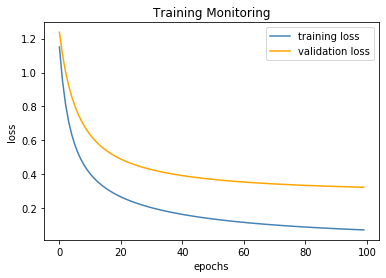

In [690]:
sub_axis = np.arange(len(trl))
plt.title('Training Monitoring')
plt.plot(sub_axis, trl, color='steelblue', label='training loss')
plt.plot(sub_axis, devl, color='orange', label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

<mark>Right<mark>

In [693]:
preds_te_count = predict_class(X_te_tfidf, w_tfidf)
print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count,average='macro'))
print('Recall:', recall_score(Y_te,preds_te_count,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te_count,average='macro'))

Accuracy: 0.86
Precision: 0.86121524577172
Recall: 0.86
F1-Score: 0.8596256972734114


Print the top-10 words for each class respectively.

In [694]:
#positive
pos_idx_1 = np.argsort(w_tfidf[:,0])[-10:]
pos_idx_2 = np.argsort(w_tfidf[:,1])[-10:]
pos_idx_3 = np.argsort(w_tfidf[:,2])[-10:]
pos_10_words_1 = list(np.array(vocab)[pos_idx_1])
pos_10_words_2 = list(np.array(vocab)[pos_idx_2])
pos_10_words_3 = list(np.array(vocab)[pos_idx_3])
print('class1:',pos_10_words_1)
print('class2:',pos_10_words_2)
print('class3:',pos_10_words_3)

class1: [('consumer', 'price'), 'killed', 'india', ('said', 'monday'), 'militants', 'murder', 'najaf', 'israeli', 'state', 'afp']
class2: ['win', 'ap', 'golf', 'game', 'games', ('athens', 'reuters'), 'coach', 'olympic', 'team', 'athens']
class3: ['billion', 'service', 'your', 'corp', 'google', 'oil', 'million', 'sales', 'business', 'company']


In [695]:
#negative 
neg_idx_1 = np.argsort(w_tfidf[:,0])[:10]
neg_idx_2 = np.argsort(w_tfidf[:,1])[:10]
neg_idx_3 = np.argsort(w_tfidf[:,2])[:10]
neg_10_words_1 = list(np.array(vocab)[neg_idx_1])
neg_10_words_2 = list(np.array(vocab)[neg_idx_2])
neg_10_words_3 = list(np.array(vocab)[neg_idx_3])
print('class1:',neg_10_words_1)
print('class2:',neg_10_words_2)
print('class3:',neg_10_words_3)

class1: ['company', ('athens', 'reuters'), 'when', 'team', 'business', 'market', 'england', 'quarter', 'corp', 'july']
class2: ['said', 'company', 'president', ('athens', 'greece'), 'prices', 'oil', 'afp', 'group', 'federal', 'troops']
class3: ['ap', 'athens', 'monday', 'afp', 'gold', 'leader', 'coach', 'left', 'night', 'men']


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

When choose a lr, just from 0.01 to try, it is too large, then try 0.001, 0.0001, if it is small, just make it a little large. But if it is too small, it need more time to converge.
The relation between training ephochs and lr: a large lr need little ephochs, on the contrary, a little lr need more ephochs.
The regularisation strength can improve the model's performance, reducing overfitting

### Now evaluate BOW-tfidf...

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.84|0.84|0.84|
| BOW-tfidf  |0.86|0.86|0.86|
